There is an issue with the resulting time series that have been used in the model so far. In short: people appear to spend more time in other provinces during the weekends as compared to during weekdays. This is not realistic and does not correspond to the raw data. Let's plot some raw data first.

# Show the issue by showing the raw data

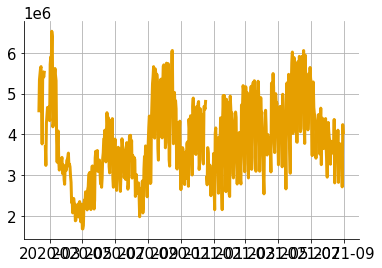

In [1]:
# takes approx 110 seconds

import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data.mobility import *


data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='1000'
PC_to='1020'

days=[]
est_staytimes=[]
for day in range(365*2):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        unprocessed_data = unprocessed_data.loc[unprocessed_data['mllp_postalcode']==PC_from]
        unprocessed_data = unprocessed_data.loc[unprocessed_data['postalcode']==PC_to]
        est_staytime = unprocessed_data.est_staytime.values[0]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

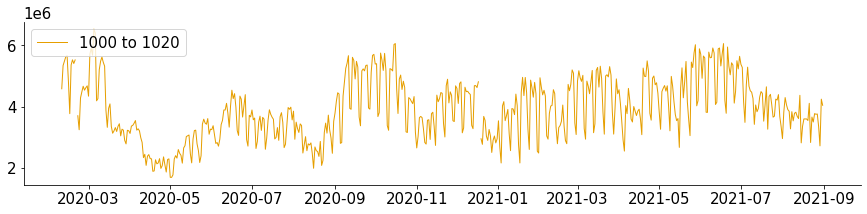

In [17]:
fig,ax = plt.subplots(figsize=(15, 3))
ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# Clearly time spent in other postal codes goes DOWN in the weekends, not up.

# Do some data cleaning and see whether the problem exists after

In [38]:
# We start off doing the same thing, but add some data cleaning steps
# Takes about ten minutes

data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='1000'
PC_to='1020'

days=[]
est_staytimes=[]
for day in range(365*2):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        
        # Pivot unprocessed data into correct origin-destination mobility matrix
        mmprox_staytime = load_mmprox(unprocessed_data, values='est_staytime')
        # Add missing postal codes (with value 0)
        mmprox_staytime = fill_missing_pc(mmprox_staytime)
        # Add missing seconds to 'stay at home' patch and subtract time spent asleep
        missing_seconds = missing_seconds_per_pc(unprocessed_data)
        mmprox_staytime = complete_home_staytime(mmprox_staytime, missing_seconds)
        # Change GDPR-protected -1 values to estimated staytime value
        est_hidden_staytime = est_hidden_staytime_per_pc(unprocessed_data)
        mmprox_staytime = GDPR_staytime(mmprox_staytime, est_hidden_staytime)
        # Add the value to the array
        est_staytime = mmprox_staytime.loc[PC_from,PC_to]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

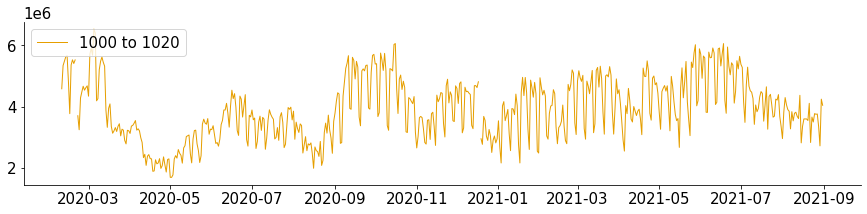

In [40]:
fig,ax = plt.subplots(figsize=(15, 3))

ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# For postal codes 1000 and 1020 there clearly is no difference here
# But perhaps the problem arises for different combinations of postal codes

# Aggregating per province

The next step is where things should clearly start going wrong, because so far everything still looks good.

In [43]:
# We start off doing the same thing, but add some data cleaning steps

data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='10000'
PC_to='21000'

agg='prov'

days=[]
est_staytimes=[]
for day in range(45):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        # Pivot unprocessed data into correct origin-destination mobility matrix
        mmprox_staytime = load_mmprox(unprocessed_data, values='est_staytime')
        # Add missing postal codes (with value 0)
        mmprox_staytime = fill_missing_pc(mmprox_staytime)
        # Add missing seconds to 'stay at home' patch and subtract time spent asleep
        missing_seconds = missing_seconds_per_pc(unprocessed_data)
        mmprox_staytime = complete_home_staytime(mmprox_staytime, missing_seconds)
        # Change GDPR-protected -1 values to estimated staytime value
        est_hidden_staytime = est_hidden_staytime_per_pc(unprocessed_data)
        mmprox_staytime = GDPR_staytime(mmprox_staytime, est_hidden_staytime)
        
        # Aggregate staytime values at the level of agg
        mmprox_staytime_agg = mm_aggregate(mmprox_staytime, agg=agg)
        # Add the value to the array
        est_staytime = mmprox_staytime_agg.loc[PC_from,PC_to]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

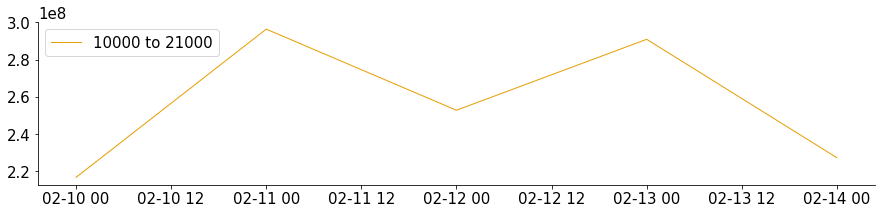

In [44]:
fig,ax = plt.subplots(figsize=(15, 3))

ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# For postal codes 1000 and 1020 there clearly is no difference here
# But perhaps the problem arises for different combinations of postal codes